In [2]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [3]:
def fix_weights_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_weights(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model
    

def brute_force_analysis_weights(model, layer_names, bw_range, f_range, fix_quant=False, parameters=None, 
                         eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_quant:
                    #fix quantization for certain layers
                    model = fix_weights_quantization(model, parameters)

                model.model = fxp_quantize.quantize_weights(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [4]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None):
    
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])

In [5]:
# config
save_path = 'C:/Users/320060820/experiments/test_models/'
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Weights/DF_MNIST/'
bw_range = np.arange(1, 9, 1)
f_range = np.arange(-2, 4, 1)
layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_12', 'conv2d_13', 
               'conv2d_14', 'conv2d_17', 'conv2d_19', 'conv2d_20', 'conv2d_21'] + ['binary']
vmax = 0.1

In [6]:
t_layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_12', 'conv2d_13', 
                 'conv2d_17', 'conv2d_19', 'binary']

# MNIST

## Quantizing Weights

In [7]:
name = 'mnist_df'
model_path = 'mnist_df/inception_v3_model_batchnorm.h5'

from test_models.mnist_df import data
_, test_data = data.get_data()

df_mnist = model_data.Model(name, test_data, path=save_path + model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
float_acc = df_mnist.evaluate_accuracy()[1]
print(float_acc)

0.9808


In [19]:
bw_r = np.arange(1, 3, 1)
f_r = np.arange(-4, 4, 1)
layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_9', 'conv2d_10', 
               'conv2d_12', 'conv2d_15', 'conv2d_16', 'conv2d_17', 'conv2d_19', 'conv2d_20', 
               'conv2d_22'] + ['binary']
s = brute_force_analysis_weights(df_mnist, layer_names, bw_r, f_r)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer conv2d_5 done.


Layer conv2d_9 done.


Layer conv2d_10 done.


Layer conv2d_12 done.


Layer conv2d_15 done.


Layer conv2d_16 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer conv2d_20 done.


Layer conv2d_22 done.


Layer binary done.


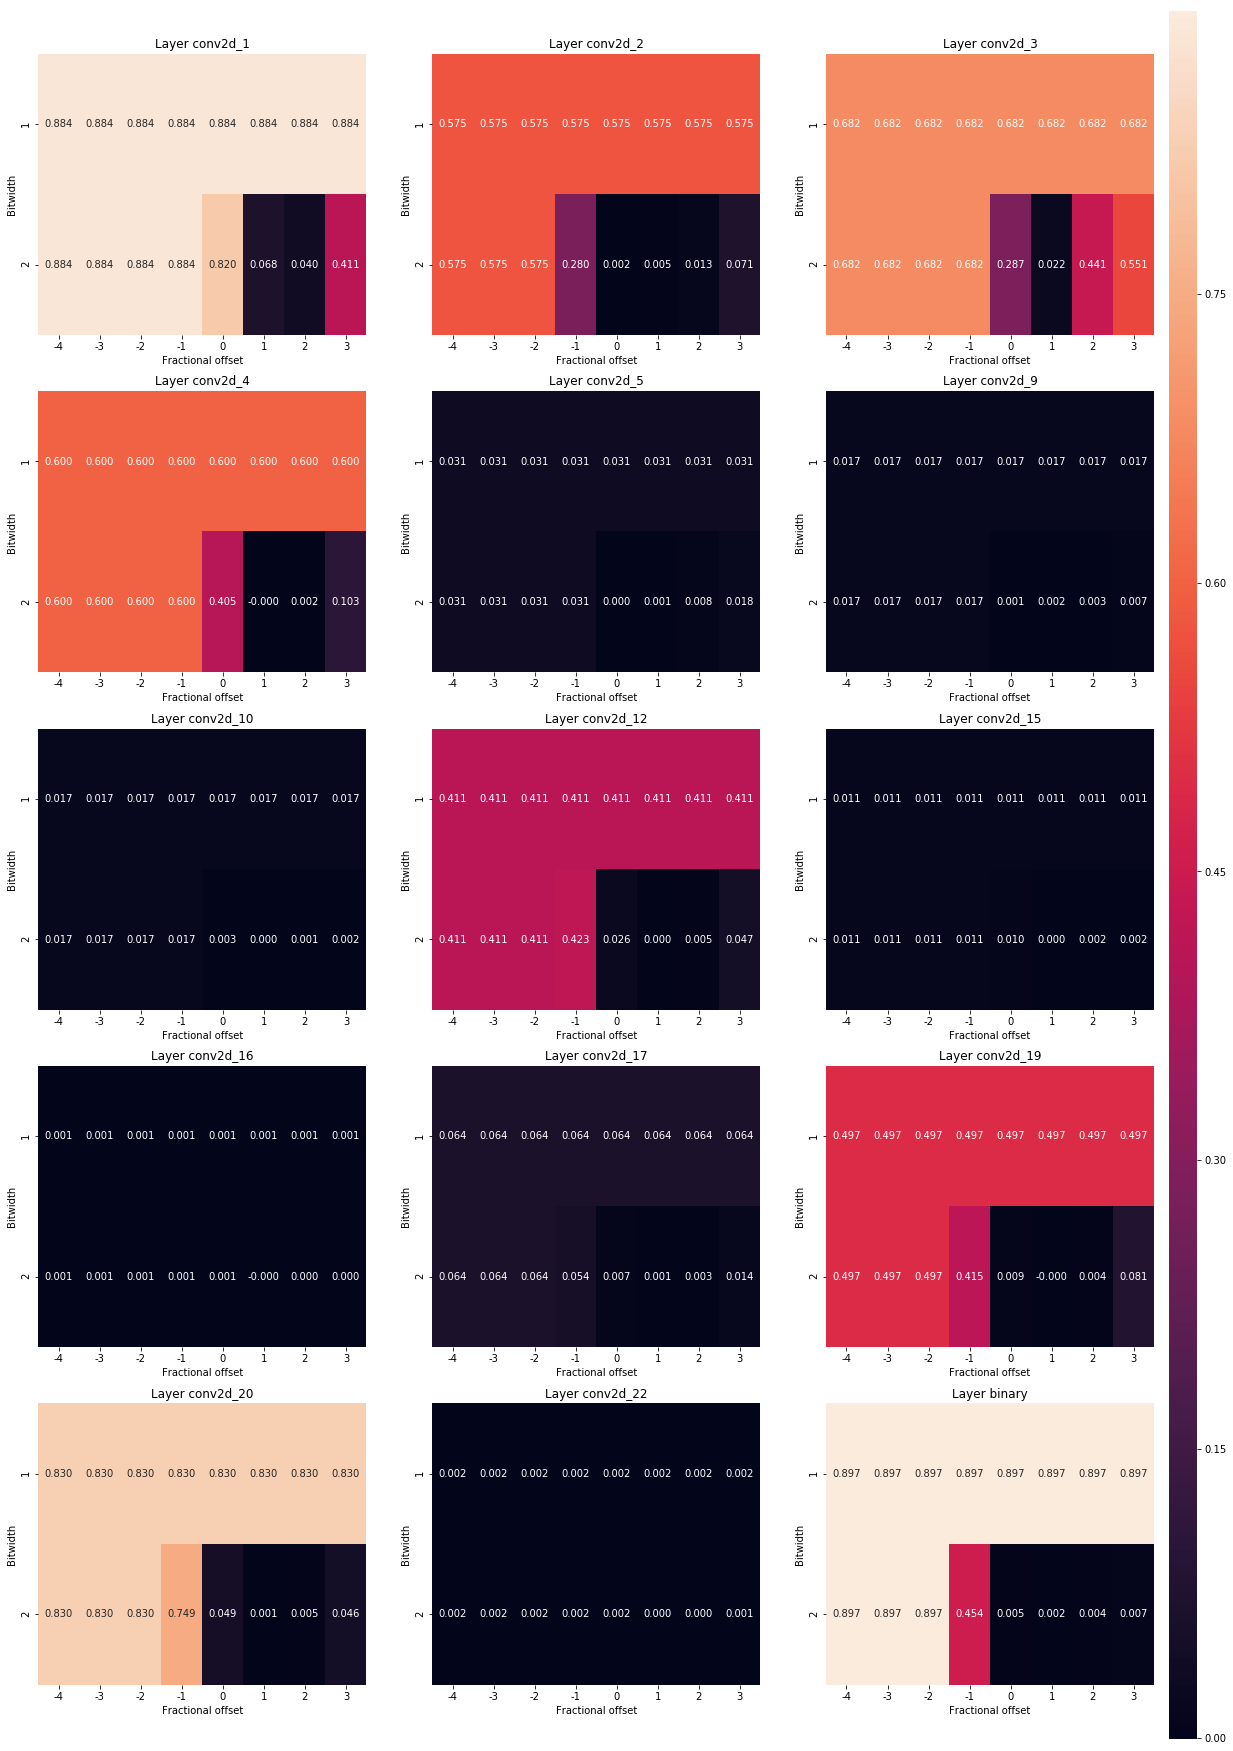

In [23]:
# short test to find the layers that are useful
plot_results(s, layer_names, 5, 3, (20, 30), 0.8, bw_r, f_r)

Layer conv2d_5 done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


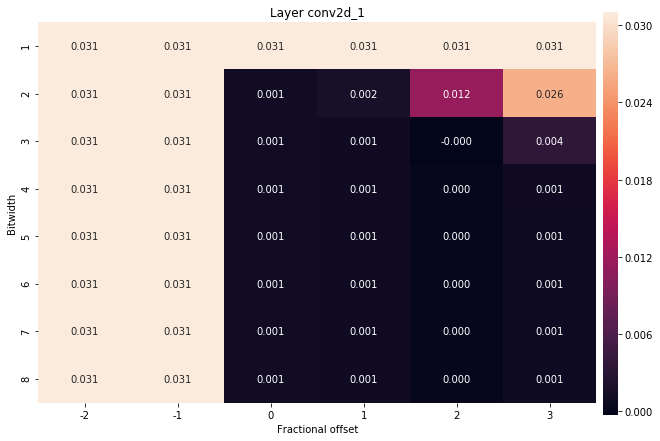

In [23]:
l_n = ['conv2d_5']
parameters = {
    'conv2d_1': [3, 2]
}
sc = brute_force_analysis_weights(df_mnist, l_n, bw_range, f_range, fix_quant=True, parameters=parameters)
plot_results(sc, l_n, 1, 1, (10, 7), 0.8, bw_range, f_range)

Layer conv2d_3 done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


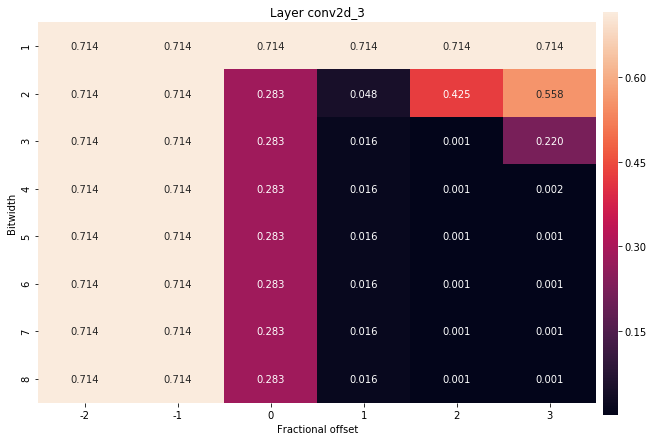

In [24]:
l_n = ['conv2d_1', 'conv2d_5', 'conv2d_3']
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_5': [2, 0]
}
sc = brute_force_analysis_weights(df_mnist, l_n[2:], bw_range, f_range, fix_quant=True, parameters=parameters)
plot_results(sc, l_n[2:], 1, 1, (10, 7), 0.8, bw_range, f_range)

Layer conv2d_6 done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


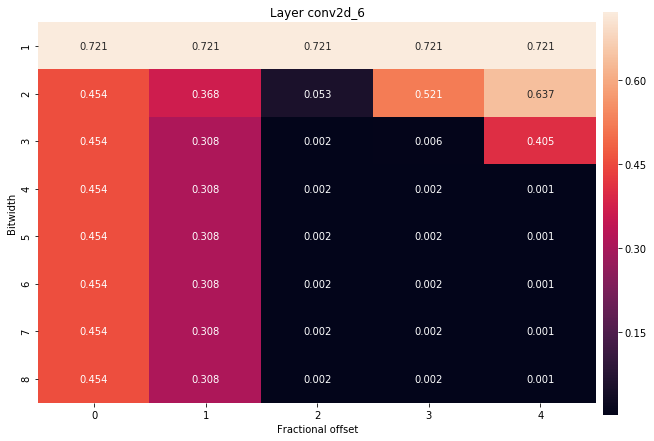

In [8]:
l_n = ['conv2d_6']
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_5': [2, 0],
    'conv2d_3': [3, 2]
}
bw_range = np.arange(1, 9, 1)
f_range = np.arange(0, 5, 1)
sc = brute_force_analysis_weights(df_mnist, l_n, bw_range, f_range, fix_quant=True, parameters=parameters)
plot_results(sc, l_n, 1, 1, (10, 7), 0.8, bw_range, f_range)

Layer conv2d_2 done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


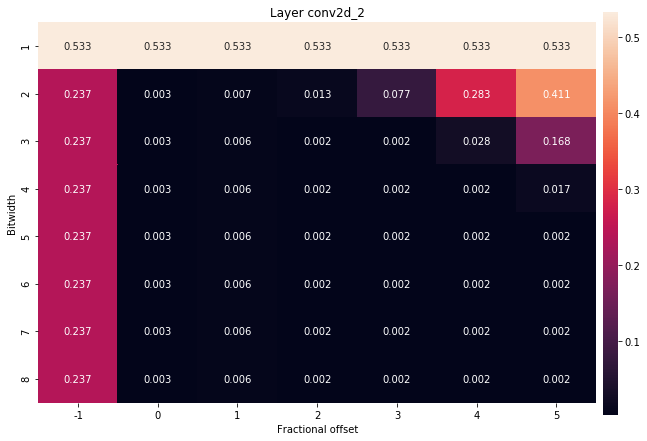

In [11]:
l_n = ['conv2d_2']
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_5': [4, 2],
    'conv2d_3': [4, 2],
    'conv2d_6': [3, 2]
}
bw_range = np.arange(1, 9, 1)
f_range = np.arange(-1, 6, 1)
sc = brute_force_analysis_weights(df_mnist, l_n, bw_range, f_range, fix_quant=True, parameters=parameters)
plot_results(sc, l_n, 1, 1, (10, 7), 0.8, bw_range, f_range)

Same point for conv 2 ends up having a higher acc drop after fixing the quant for the previous layers. Therefore you end up needing to quantize this layer more conservatively. This is not so ideal because you see some level of dependence on the other layers.

Layer conv2d_2 done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


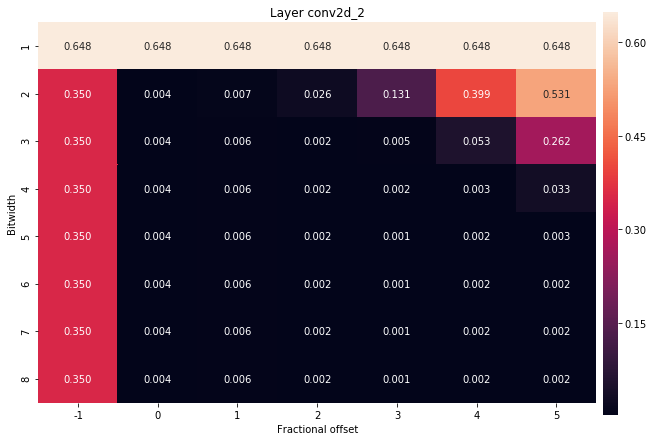

In [9]:
l_n = ['conv2d_2']
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_5': [2, 0],
    'conv2d_3': [3, 2],
    'conv2d_6': [3, 2]
}
bw_range = np.arange(1, 9, 1)
f_range = np.arange(-1, 6, 1)
sc = brute_force_analysis_weights(df_mnist, l_n, bw_range, f_range, fix_quant=True, parameters=parameters)
plot_results(sc, l_n, 1, 1, (10, 7), 0.8, bw_range, f_range)

Layer conv2d_2 done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


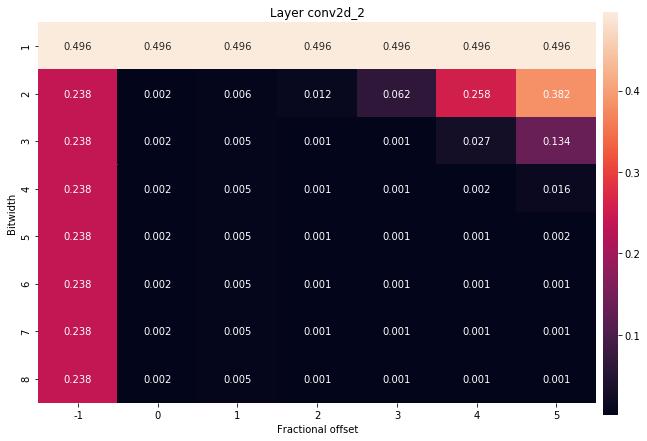

In [11]:
l_n = ['conv2d_2']
parameters = {
    'conv2d_1': [7, 6],
    'conv2d_5': [4, 2],
    'conv2d_3': [4, 2],
    'conv2d_6': [3, 2]
}
bw_range = np.arange(1, 9, 1)
f_range = np.arange(-1, 6, 1)
sc = brute_force_analysis_weights(df_mnist, l_n, bw_range, f_range, fix_quant=True, parameters=parameters)
plot_results(sc, l_n, 1, 1, (10, 7), 0.8, bw_range, f_range)

In [13]:
np.sqrt(23*(0.3**2))

1.4387494569938157

In [30]:
scores_1 = brute_force_analysis_weights(df_mnist, t_layer_names, bw_range, f_range)
np.save(output_path + 'scores_1', arr=scores_1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


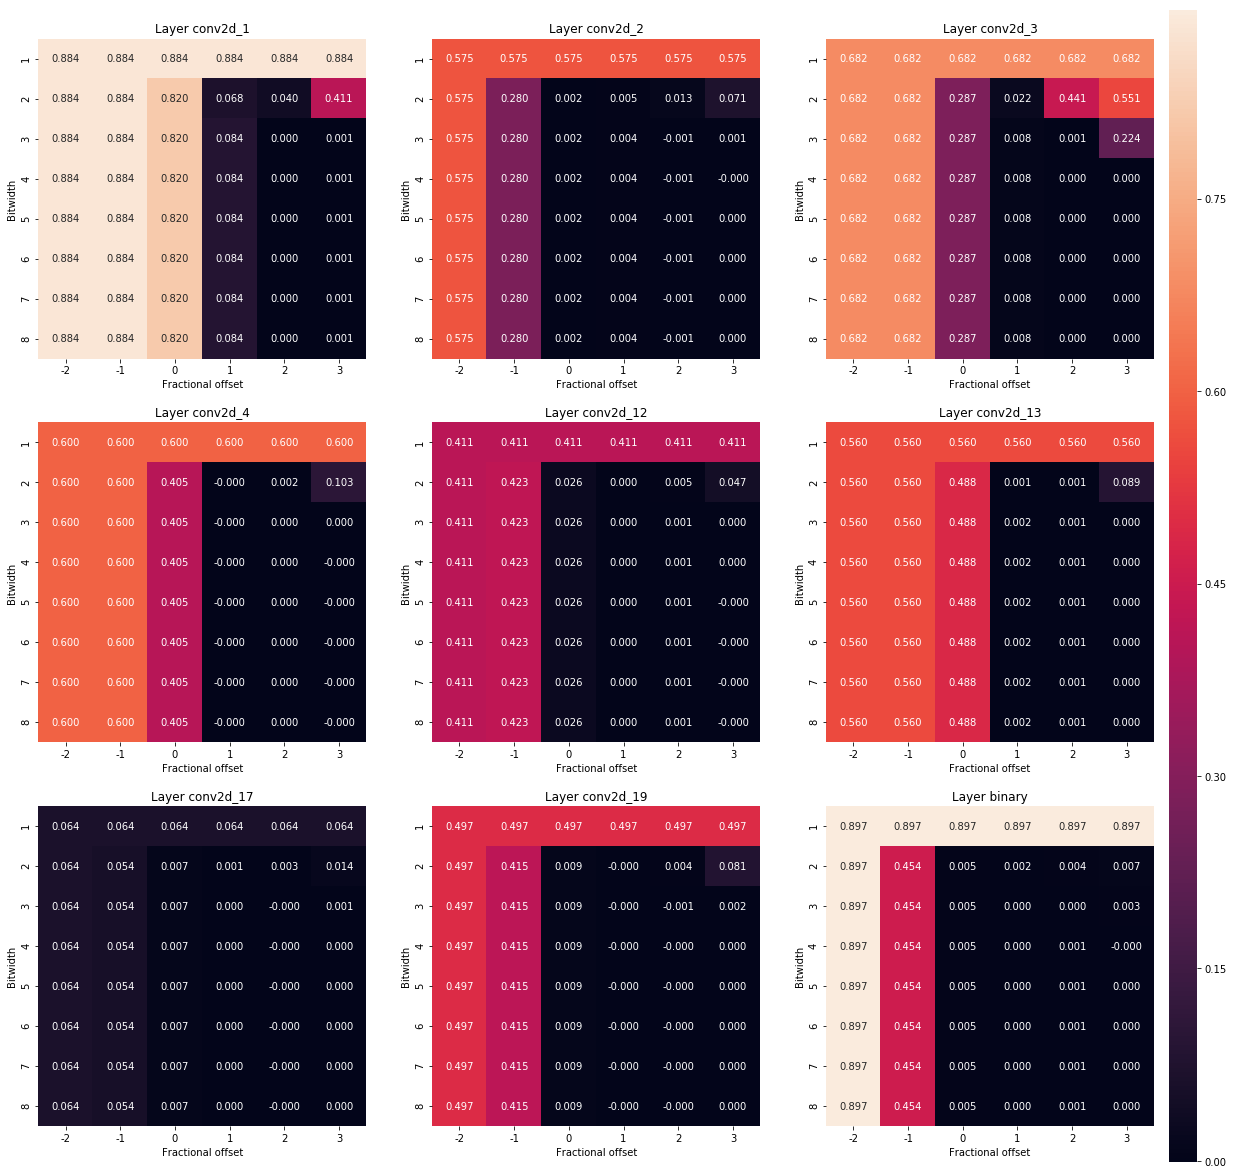

In [33]:
plot_results(scores_1, t_layer_names, 3, 3, (20, 20), 0.8, bw_range, f_range)

In [34]:
parameters = {
    'conv2d_1': [3, 2]
}
scores_2 = brute_force_analysis_weights(df_mnist, t_layer_names[1:], bw_range, f_range, fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_2', arr=scores_2)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


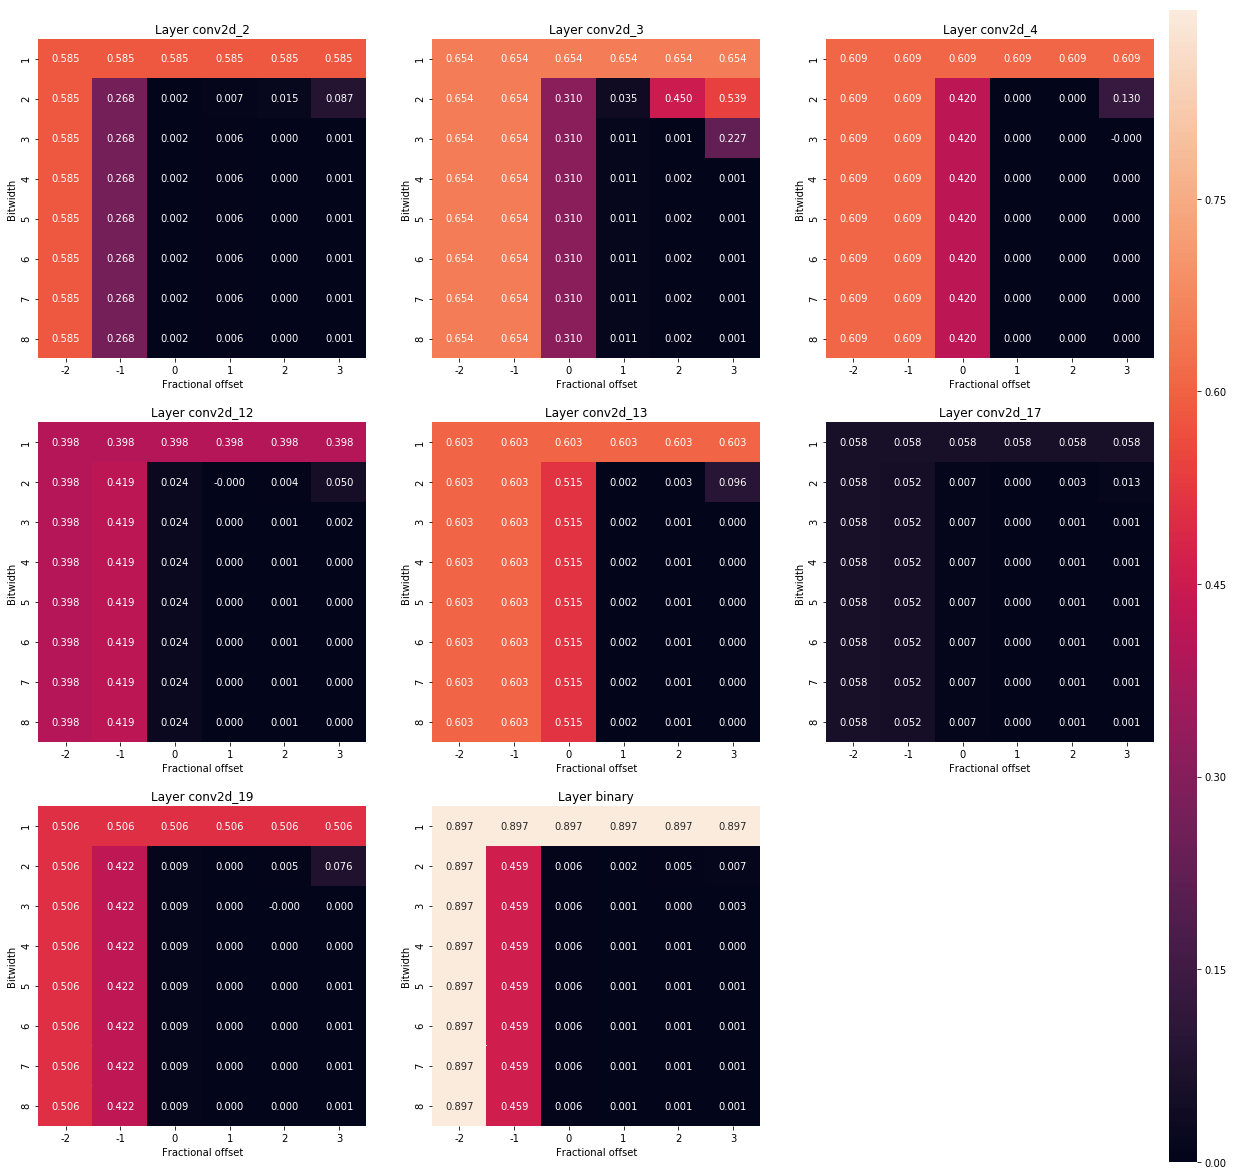

In [37]:
plot_results(scores_2, t_layer_names[1:], 3, 3, (20, 20), 0.8, bw_range, f_range)

In [49]:
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2]
}
scores_3 = brute_force_analysis_weights(df_mnist, t_layer_names[2:], bw_range, f_range, fix_quant=True, parameters=parameters)

np.save(output_path + 'scores_3', arr=scores_3)

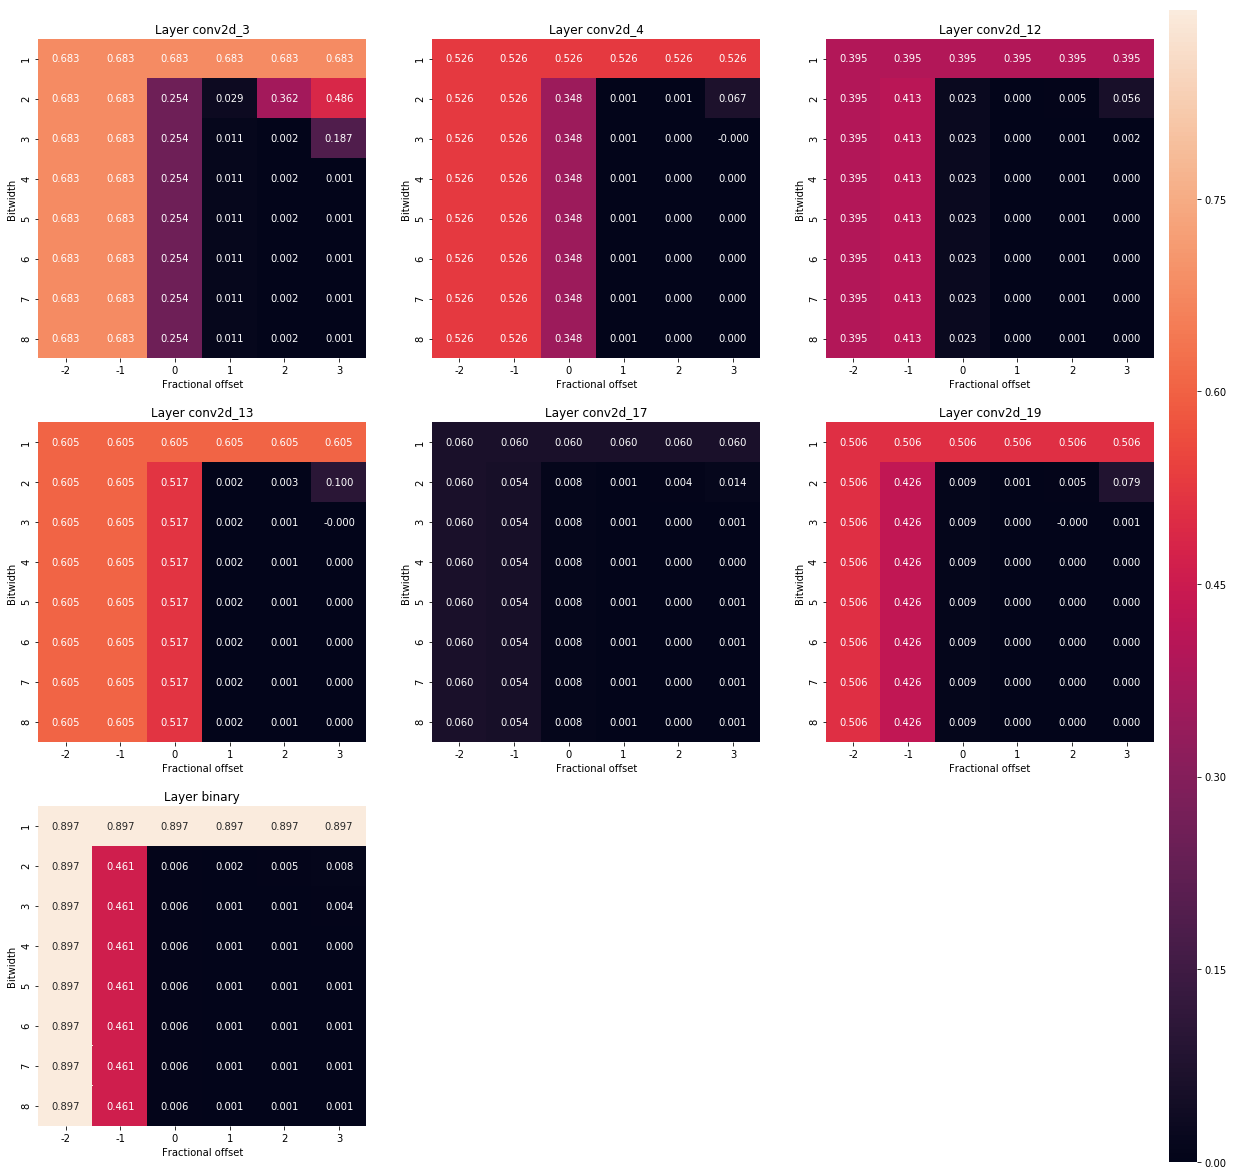

In [41]:
plot_results(scores_3, t_layer_names[2:], 3, 3, (20, 20), 0.8, bw_range, f_range)

In [46]:
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2]
}
scores_4 = brute_force_analysis_weights(df_mnist, t_layer_names[3:], bw_range, f_range, fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_4', arr=scores_4)

Layer conv2d_4 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


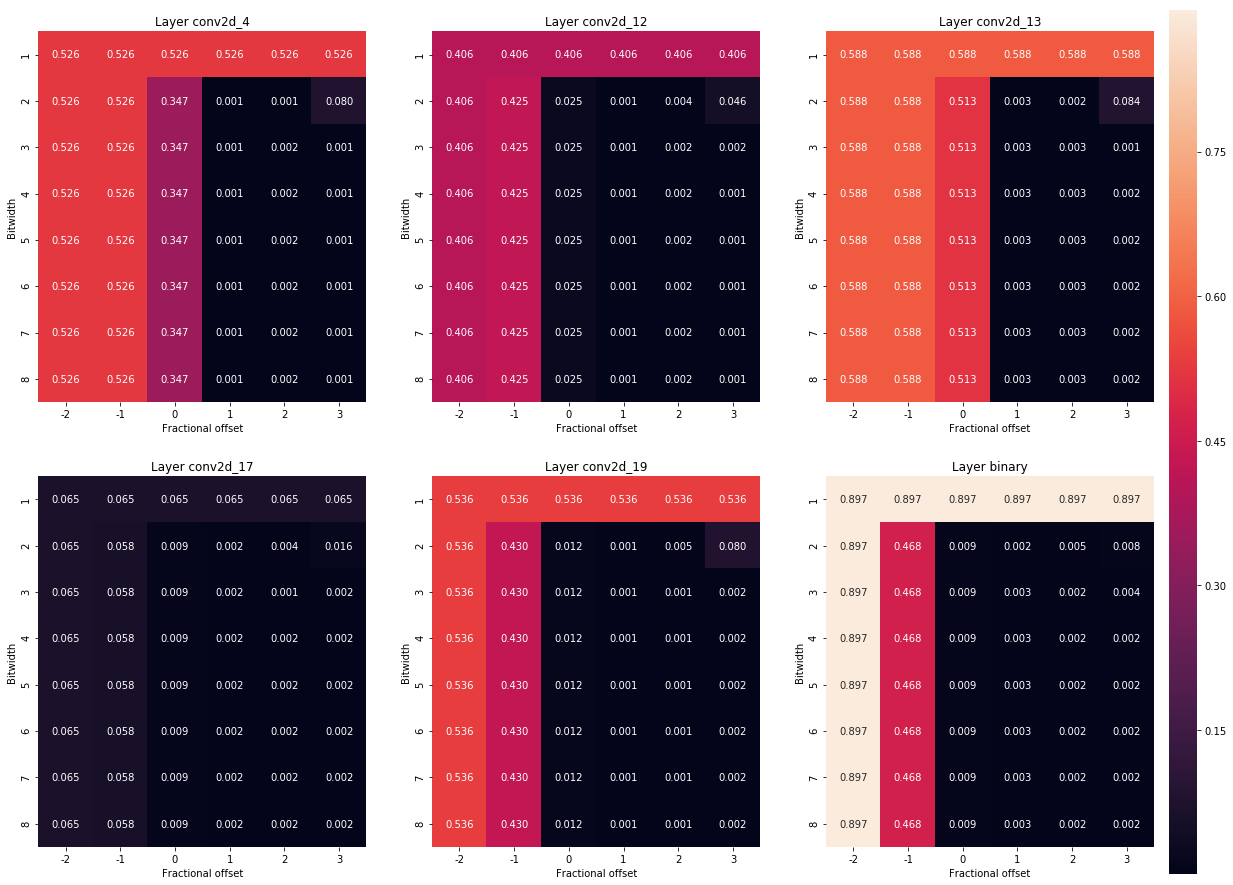

In [48]:
plot_results(scores_4, t_layer_names[3:], 2, 3, (20, 15), 0.8, bw_range, f_range)

In [50]:
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [2, 1]
}
scores_5 = brute_force_analysis_weights(df_mnist, t_layer_names[4:], bw_range, f_range, fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_5', arr=scores_5)

Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


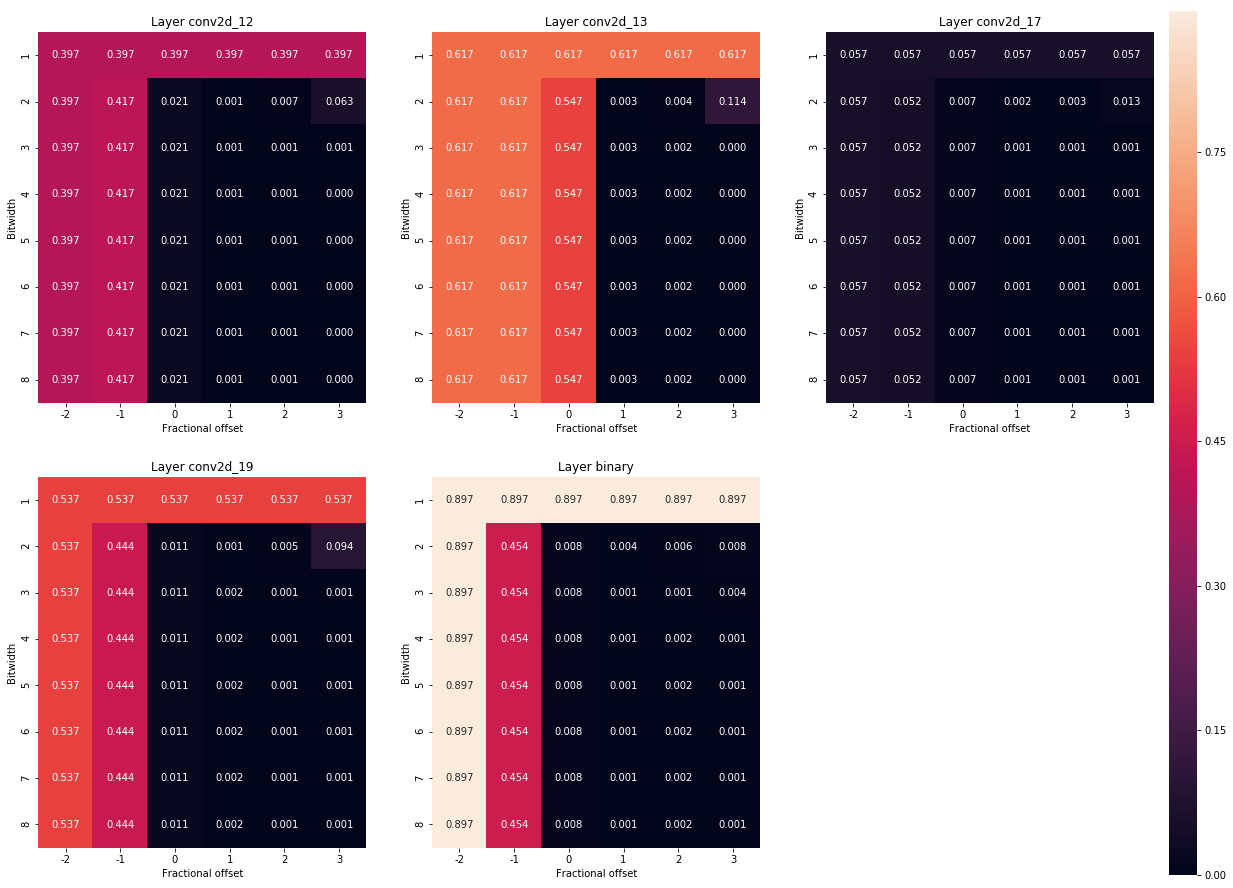

In [51]:
plot_results(scores_5, t_layer_names[4:], 2, 3, (20, 15), 0.8, bw_range, f_range)

In [55]:
# alternate path
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [3, 3],
}
scores_5_alt = brute_force_analysis_weights(df_mnist, t_layer_names[4:], bw_range, f_range, fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_5_alt', arr=scores_5_alt)

Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


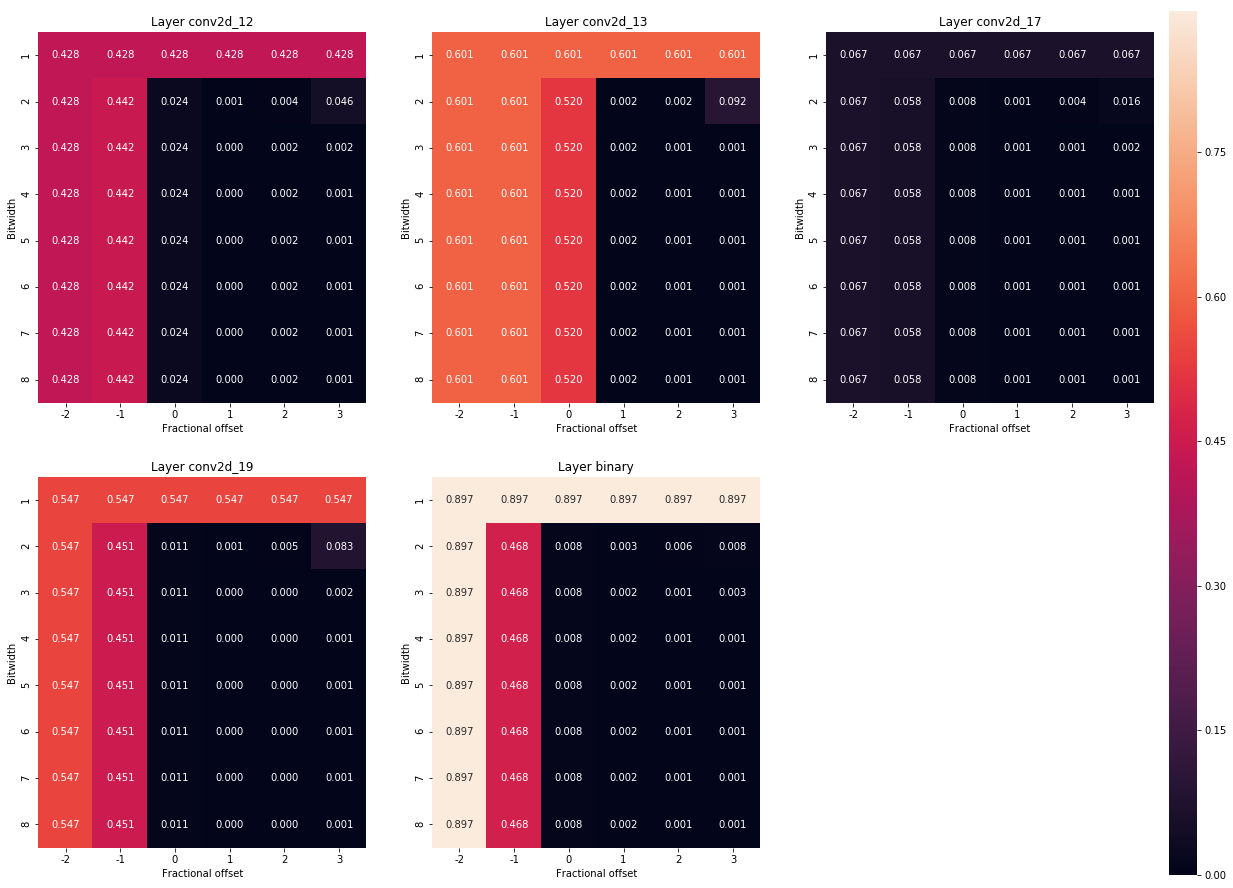

In [57]:
plot_results(scores_5_alt, t_layer_names[4:], 2, 3, (20, 15), 0.8, bw_range, f_range)

In [52]:
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [2, 1],
    'conv2d_12': [2, 1]
}
scores_6 = brute_force_analysis_weights(df_mnist, t_layer_names[5:], bw_range, f_range, fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_6', arr=scores_6)

Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


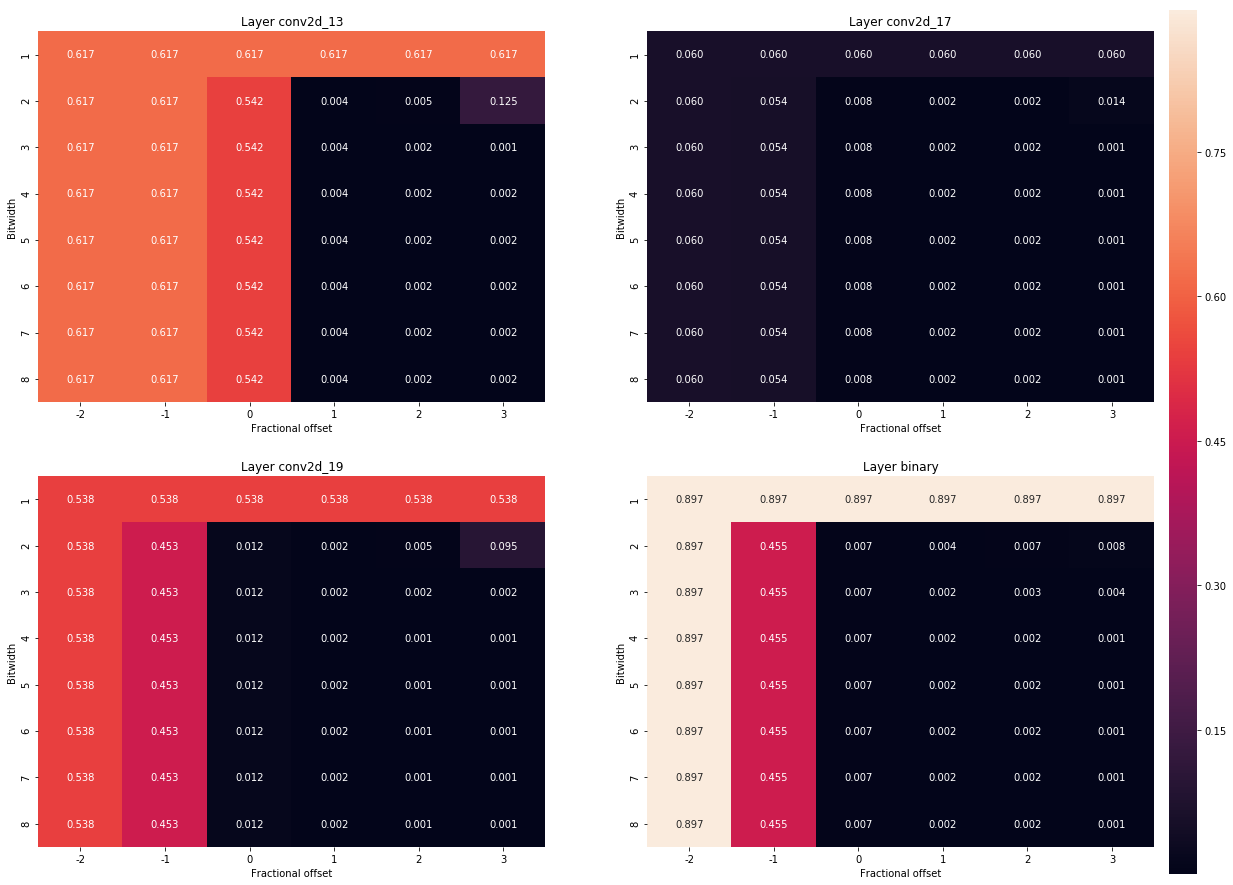

In [53]:
plot_results(scores_6, t_layer_names[5:], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [54]:
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [2, 1],
    'conv2d_12': [2, 1],
    'conv2d_13': [3, 3]
}
scores_7 = brute_force_analysis_weights(df_mnist, t_layer_names[6:], bw_range, f_range, fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_7', arr=scores_7)

Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


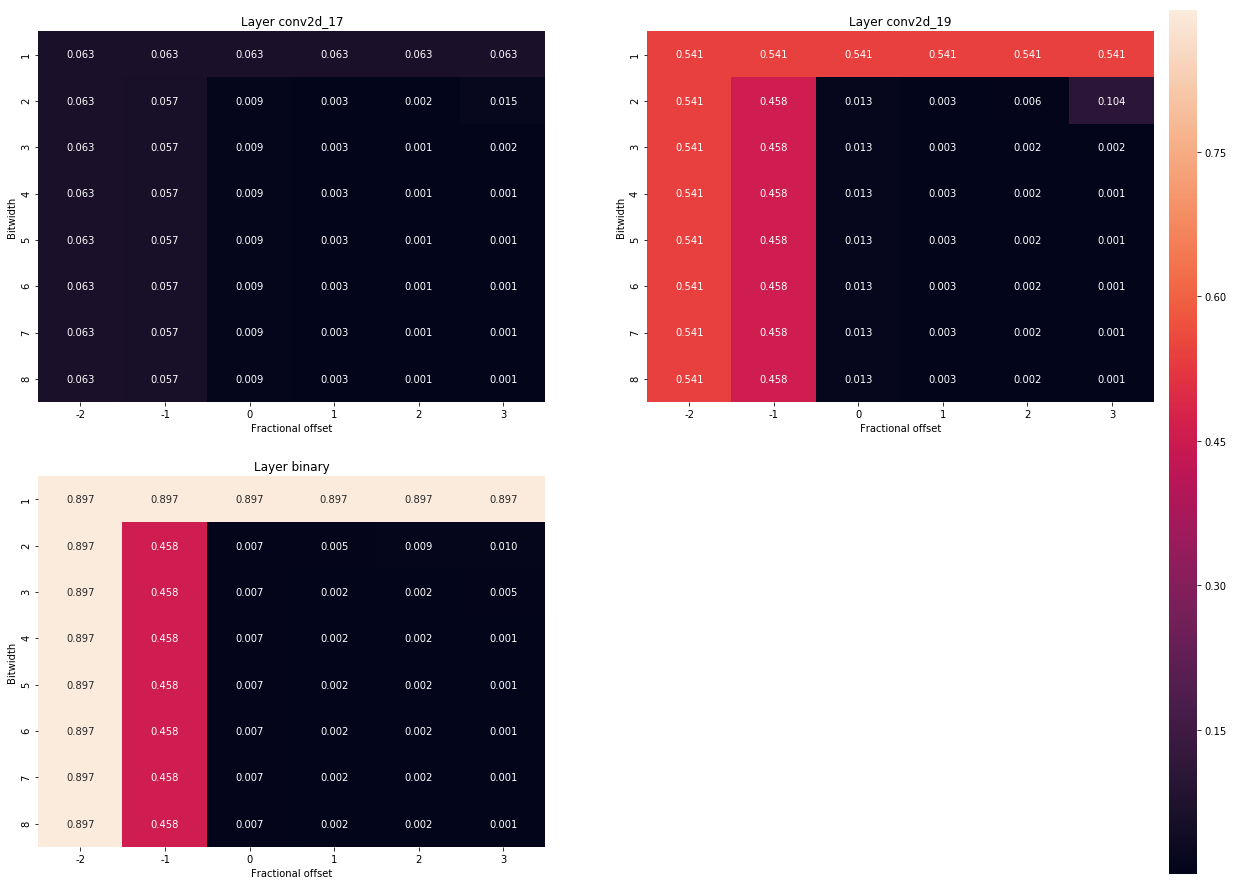

In [56]:
plot_results(scores_7, t_layer_names[6:], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [58]:
parameters = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [2, 1],
    'conv2d_12': [2, 1],
    'conv2d_13': [3, 3], 
    'conv2d_17': [2, 2]
}
scores_8 = brute_force_analysis_weights(df_mnist, t_layer_names[7:], bw_range, f_range, fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_8', arr=scores_8)

Layer conv2d_19 done.


Layer binary done.


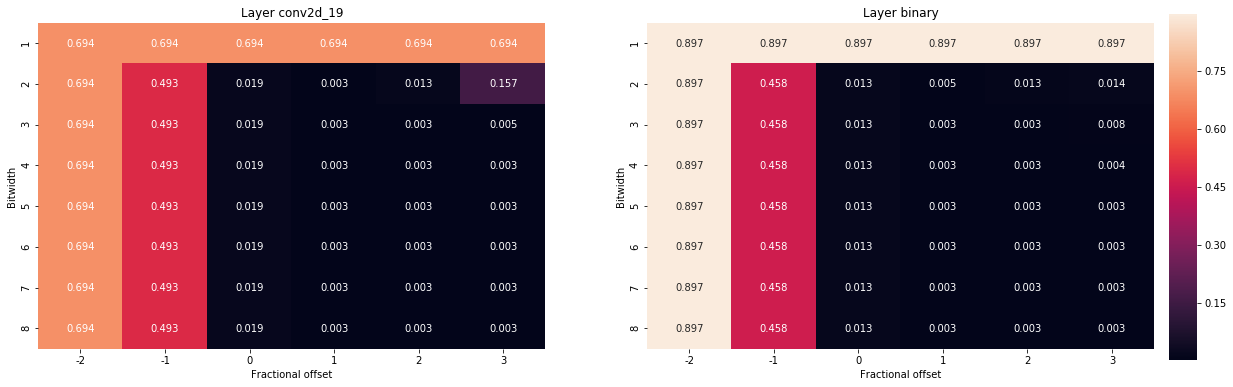

In [61]:
plot_results(scores_8, t_layer_names[7:], 1, 2, (20, 6), 0.8, bw_range, f_range)

In [23]:
df_mnist.load_model_from_path()
df_mnist.evaluate_accuracy()[1]

0.9808

In [24]:
w_quant_params = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [2,  1],
    'conv2d_12': [2, 1],
    'conv2d_13': [3, 3], 
    'conv2d_17': [2, 2],
    'conv2d_19': [3, 1], 
    'binary': [3, 1]
}
df_mnist.load_model_from_path()
df_mnist = fix_weights_quantization(df_mnist, w_quant_params)
df_mnist.evaluate_accuracy()[1]

0.9762

## Quantizing Biases

In [9]:
def fix_biases_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_biases(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model


def brute_force_analysis_biases(model, layer_names, bw_range, f_range, fix_w_quant=False, w_parameters=None,
                                fix_b_quant=False, b_parameters=None, eval_metric='acc_drop'):
    
    if (fix_w_quant and w_parameters is None) or (fix_b_quant and b_parameters is None):
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_w_quant:
                    model = fix_weights_quantization(model, w_parameters)
                    
                if fix_b_quant:
                    model = fix_biases_quantization(model, b_parameters)

                model.model = fxp_quantize.quantize_biases(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [12]:
f_range = np.arange(0, 7, 1)

In [13]:
w_quant_params = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [2,  1],
    'conv2d_12': [2, 1],
    'conv2d_13': [3, 3], 
    'conv2d_17': [2, 2],
    'conv2d_19': [3, 1], 
    'binary': [3, 1]
}
scores_b_1 = brute_force_analysis_biases(df_mnist, t_layer_names, bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params)
np.save(output_path + 'scores_b_1', arr=scores_b_1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


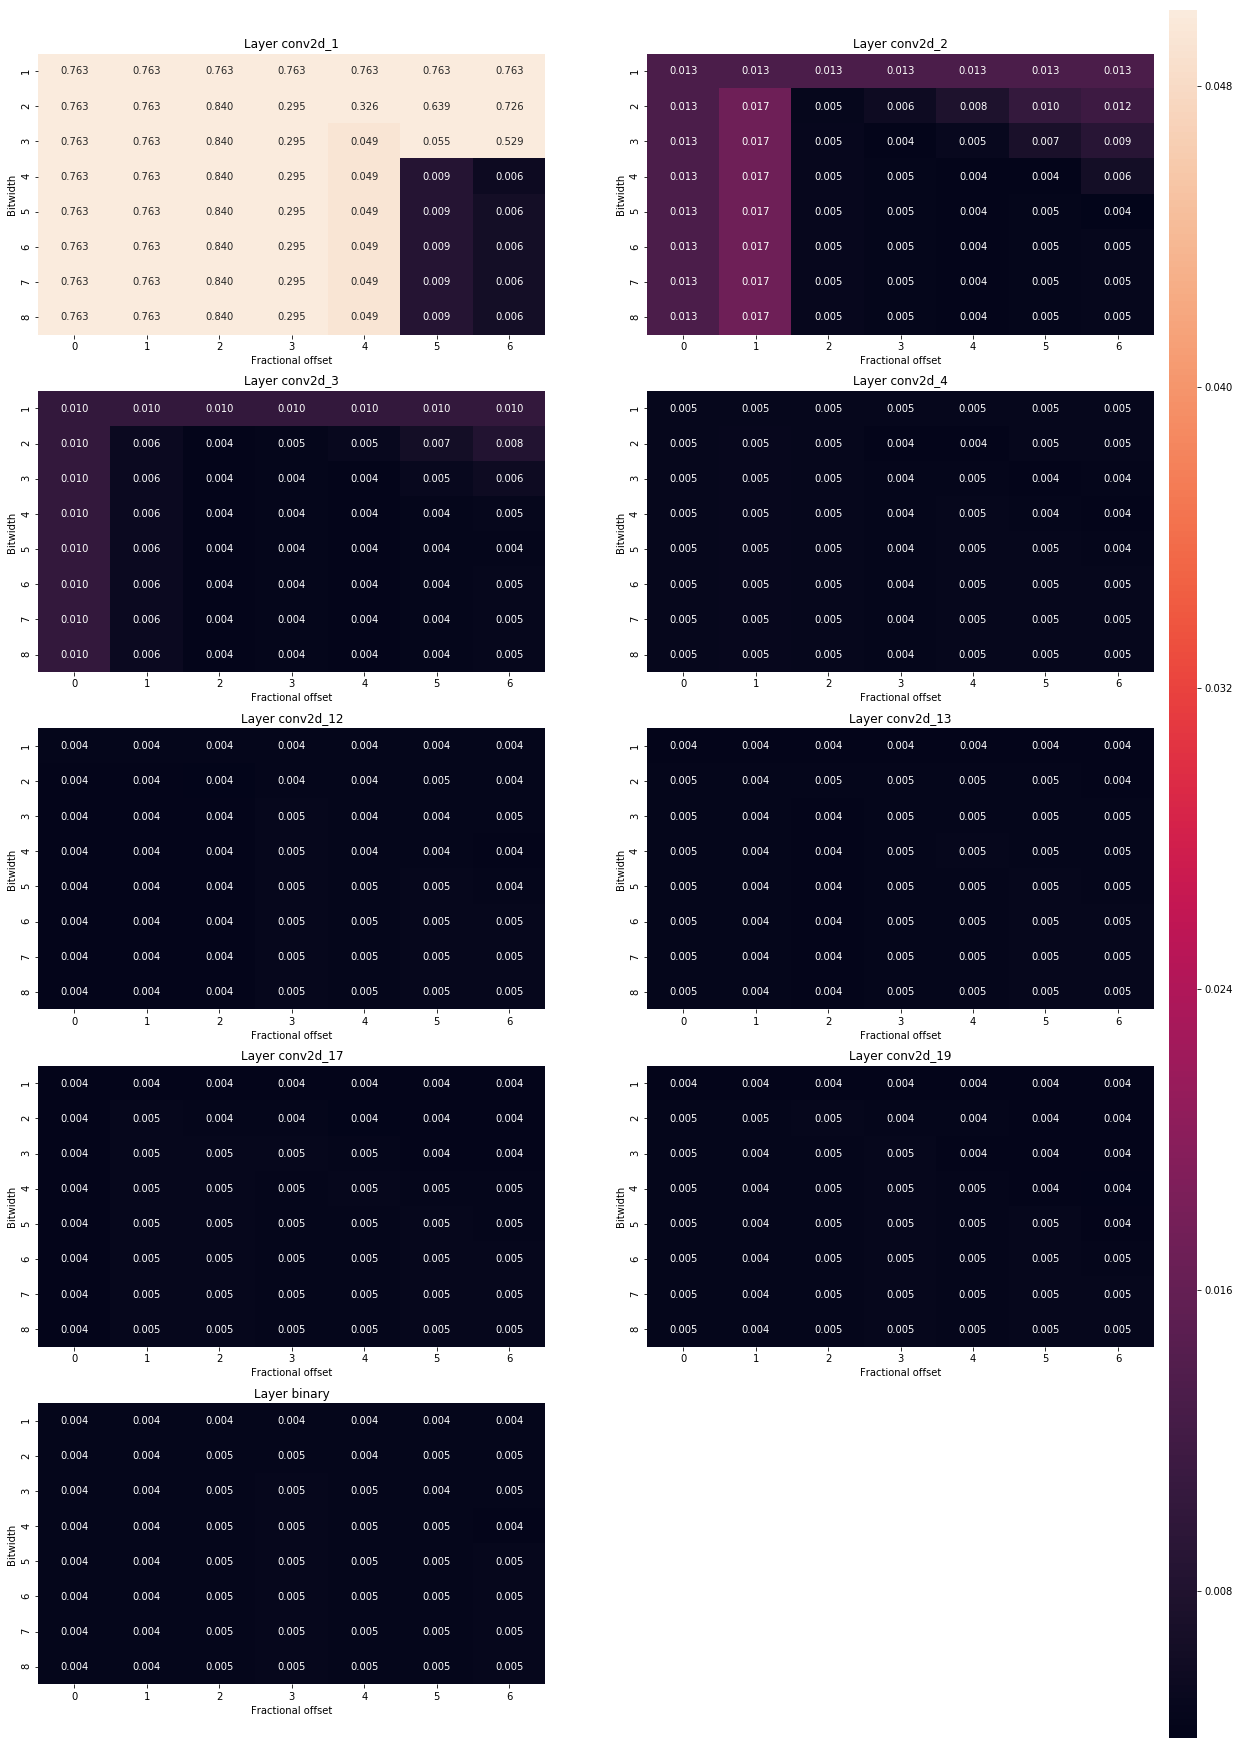

In [15]:
plot_results(scores_b_1, t_layer_names, 5, 2, (20, 30), 0.8, bw_range, f_range, vmax=0.05)

In [17]:
w_quant_params = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [2,  1],
    'conv2d_12': [2, 1],
    'conv2d_13': [3, 3], 
    'conv2d_17': [2, 2],
    'conv2d_19': [3, 1], 
    'binary': [3, 1]
}

b_quant_params = {
    'conv2d_1': [6, 7],
    'conv2d_2': [4, 4],
    'conv2d_3': [3, 2],
    'conv2d_4': [3, 2]
}
scores_b_2 = brute_force_analysis_biases(df_mnist, t_layer_names[4:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)
np.save(output_path + 'scores_b_2', arr=scores_b_2)

Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer binary done.


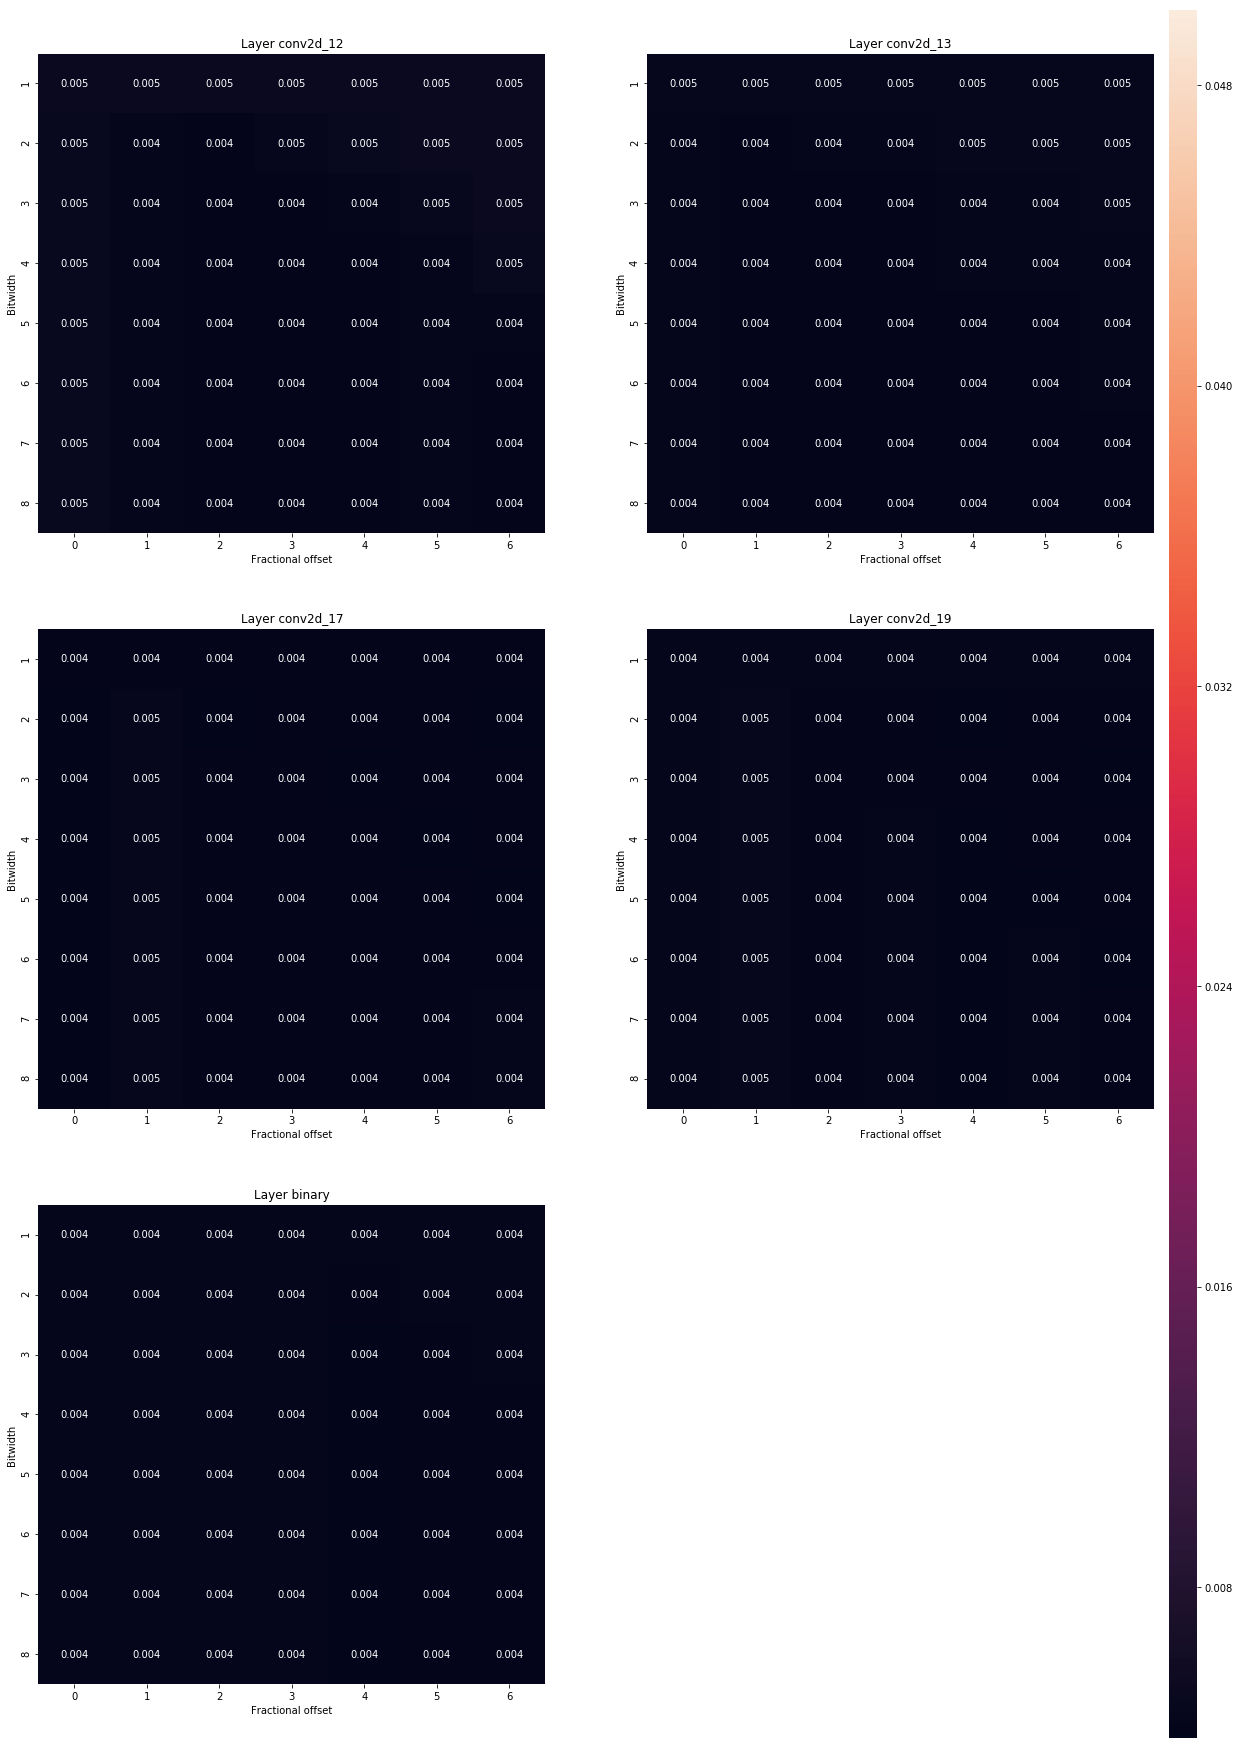

In [18]:
plot_results(scores_b_2, t_layer_names[4:], 3, 2, (20, 30), 0.8, bw_range, f_range, vmax=0.05)

In [19]:
w_quant_params = {
    'conv2d_1': [3, 2],
    'conv2d_2': [3, 2],
    'conv2d_3': [3, 2], 
    'conv2d_4': [2,  1],
    'conv2d_12': [2, 1],
    'conv2d_13': [3, 3], 
    'conv2d_17': [2, 2],
    'conv2d_19': [3, 1], 
    'binary': [3, 1]
}

b_quant_params = {
    'conv2d_1': [6, 7],
    'conv2d_2': [4, 4],
    'conv2d_3': [3, 2],
    'conv2d_4': [3, 2],
    'conv2d_12': [2, 1],
    'conv2d_13': [2, 0],
    'conv2d_17': [1, 0],
    'conv2d_19': [1, 0]
}
scores_b_3 = brute_force_analysis_biases(df_mnist, t_layer_names[-1:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)
np.save(output_path + 'scores_b_3', arr=scores_b_3)

Layer binary done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


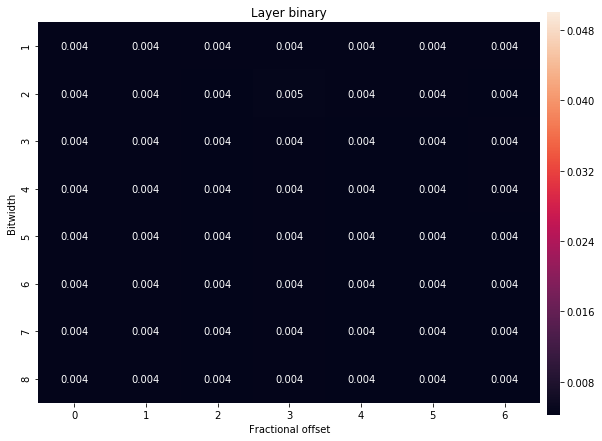

In [21]:
plot_results(scores_b_3, t_layer_names[-1:], 1, 1, (9, 7), 0.8, bw_range, f_range, vmax=0.05)